In [1]:
import torch
import PIL
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from modules.datasets import MultiLabelDataset,ContrastiveDataset

C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def inverse_transform(image:torch.Tensor):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    return inv_normalize(image).numpy().transpose(1,2,0).clip(0,1)

## Carparts Dataset

In [3]:
multiLabelDataset = MultiLabelDataset("./Carparts",label_index=1)
len(multiLabelDataset)

27618

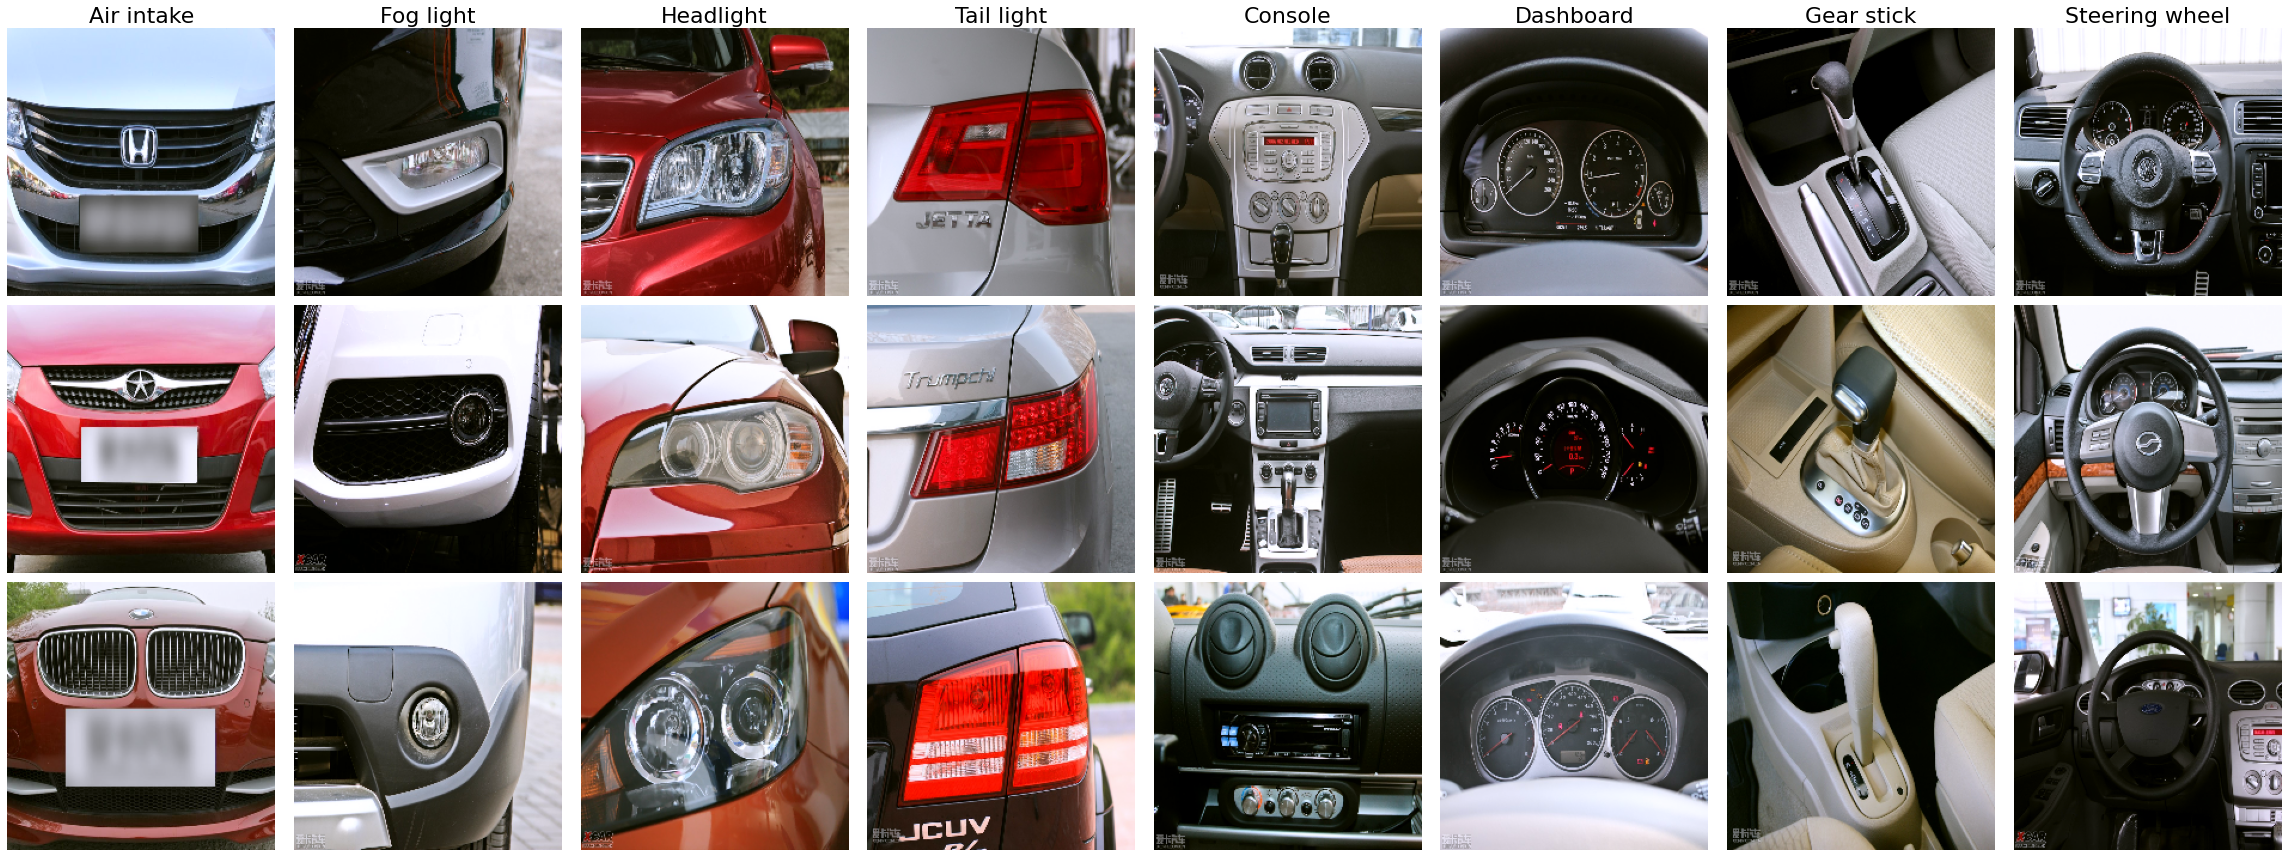

In [4]:
rows = 3
columns = len(multiLabelDataset.datasets)
index = 1
plt.figure(figsize=(columns*4,rows*4))
for k in range(rows):
    for i,subDataset in enumerate(multiLabelDataset.datasets):
        
        plt.subplot(rows,columns,index)
        dataset = multiLabelDataset.datasets[subDataset]
        image = dataset[k][0]
        image = inverse_transform(image)
        plt.imshow(image)
        plt.axis('off')
        index += 1
        if k == 0:
            plt.title(subDataset,fontsize=22)

   
plt.tight_layout() 
plt.show()

## Augmentations

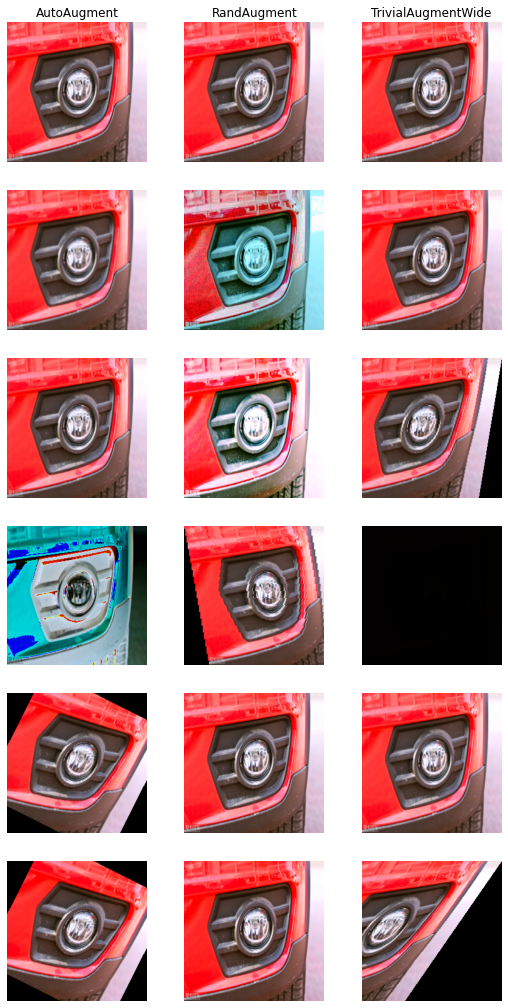

In [5]:
from torchvision.transforms import AutoAugment,RandAugment,TrivialAugmentWide
from modules.datasets import AugmentingDataset
from timm.data.mixup import Mixup

# Build a Small Dataset
multiLabelDataset = MultiLabelDataset("./Carparts",label_index=1,max_size_per_class=1,max_classes=1,transform=transforms.Compose([transforms.Resize((224,224))]))
len(multiLabelDataset)

plt.figure(figsize=(3*3,6*3))

for i,augmentation in enumerate([AutoAugment,RandAugment,TrivialAugmentWide]):
    aug = augmentation()
    augmented_dataset = AugmentingDataset(multiLabelDataset,augmentation=aug,transforms=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),factor=6)
    for k in range(len(augmented_dataset)):
        image = augmented_dataset[k][0]
        plt.subplot(6,3,(k)*3+i+1)
        
        plt.imshow(inverse_transform(image))
        plt.axis('off')
        if k == 0:
            plt.title(type(aug).__name__)
            
plt.show()

## Tiny Imagenet

In [6]:
multiLabelDataset = MultiLabelDataset("./tiny-imagenet-200/train",transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
print(f"Images: {len(multiLabelDataset)}")
print(f"Classes: {len(multiLabelDataset.datasets)}")

Images: 100000
Classes: 200


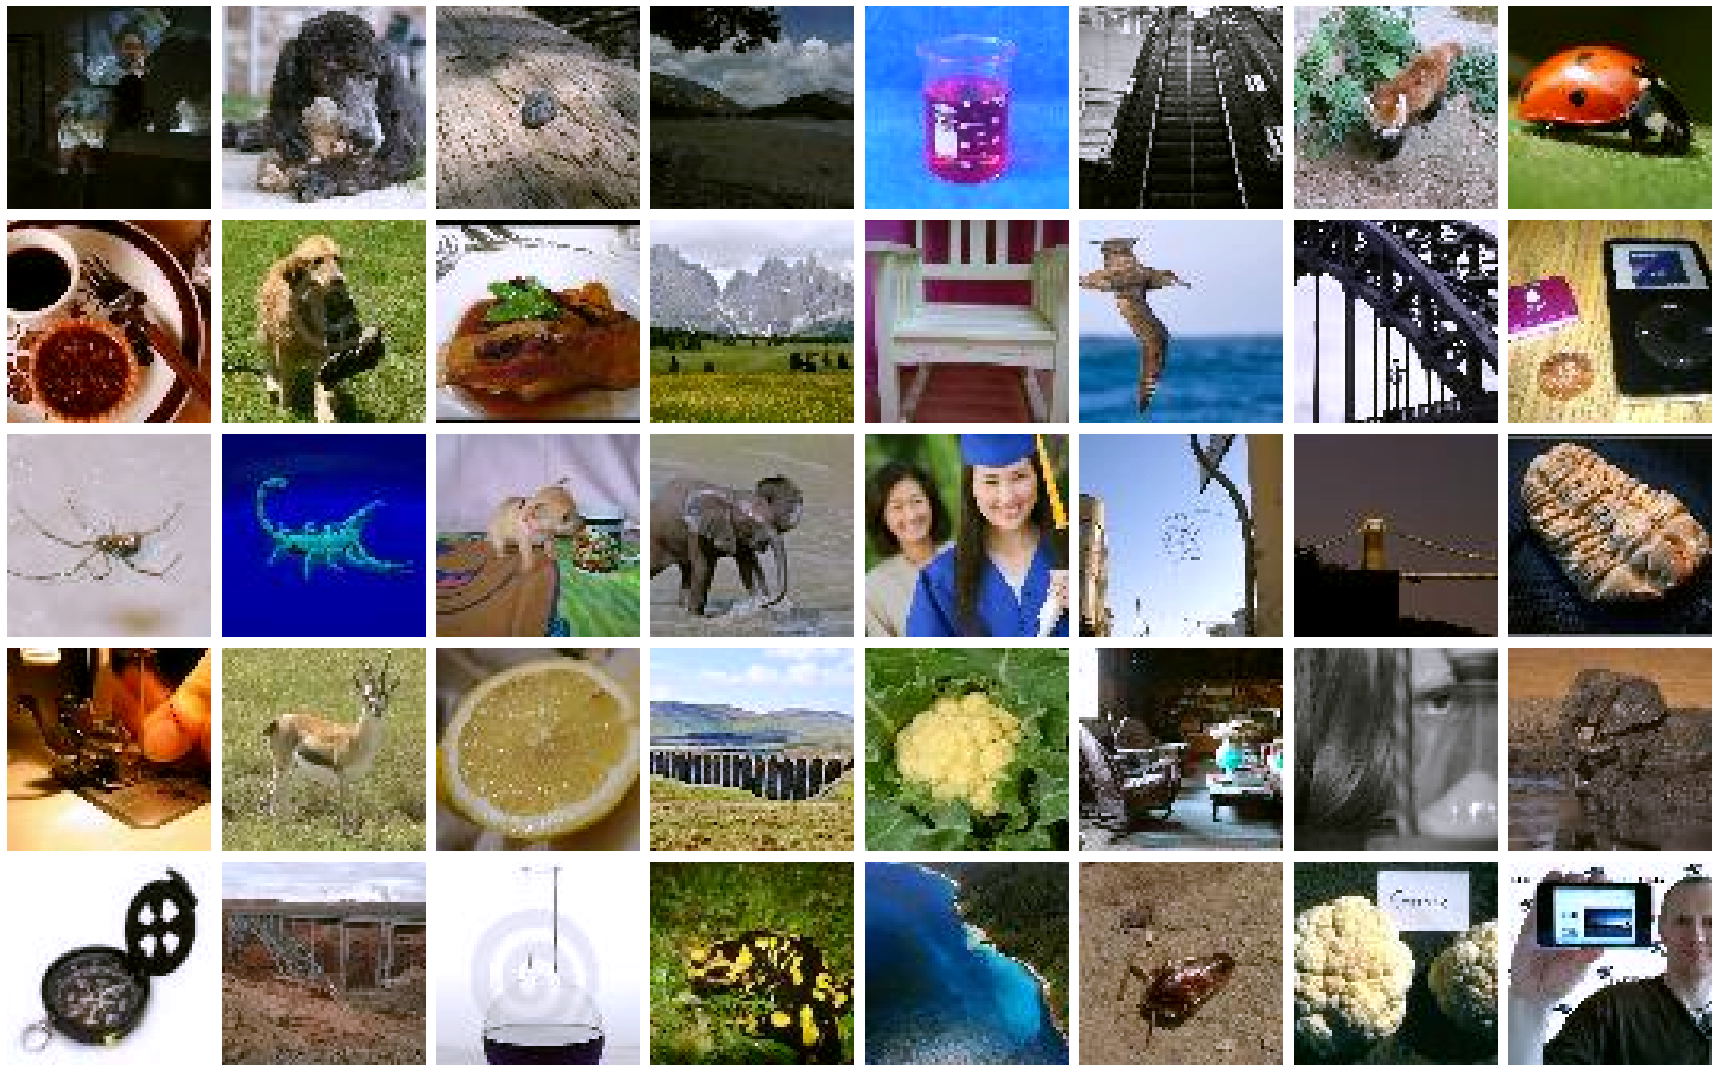

In [12]:
import random
random.seed(42)

rows = 5
cols = 8

plt.figure(figsize=(columns*3,rows*3))

for i in range(rows):
    for j in range(cols):
        plt.subplot(rows,cols,i*cols+j+1)
        image = multiLabelDataset[random.randrange(0,len(multiLabelDataset))][0]
        plt.imshow(inverse_transform(image))
        plt.axis('off')
 
plt.tight_layout()       
plt.show()


In [7]:
conDataset = ContrastiveDataset(multiLabelDataset)

Building Contrastive Pairs: 100%|██████████| 100000/100000 [00:15<00:00, 6439.54it/s]


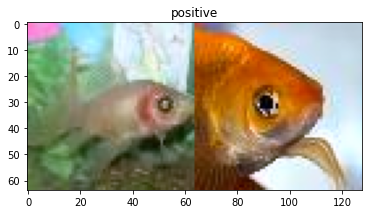

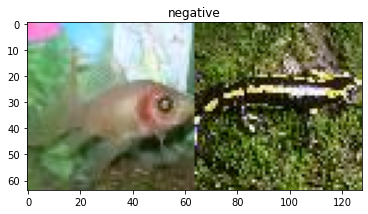

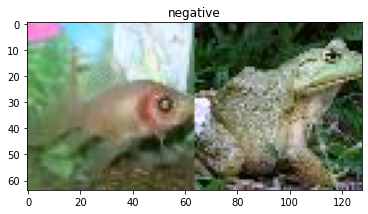

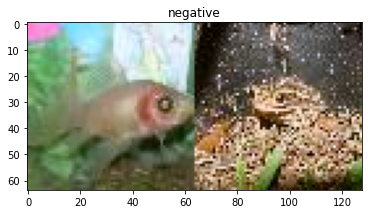

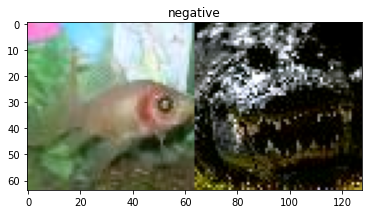

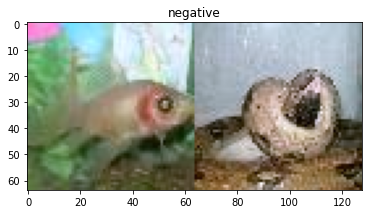

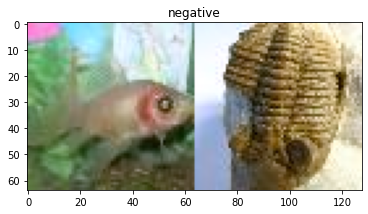

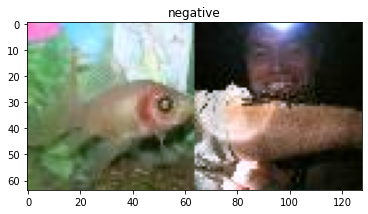

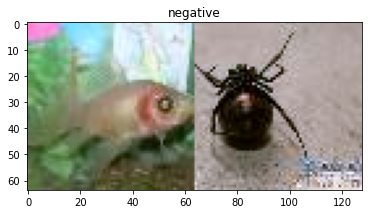

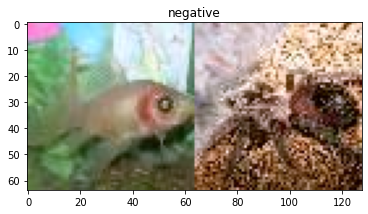

In [8]:
def combine_contrastive(sample):
    img1,img2,label = sample
    img1 = inverse_transform(img1)
    img2 = inverse_transform(img2)
    combined = np.concatenate((img1, img2), axis = 1)
    return combined , "negative" if int(label.numpy()[0]) == 0 else "positive"
    
for i in range(10):
    sample = conDataset[i]
    combined,label = combine_contrastive(sample)
    plt.imshow(combined)
    plt.title(label)
    plt.show()